In [1]:
import os
os.chdir("../")

In [30]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# Model
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

# Others
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import numpy as np

In [3]:
register_coco_instances("spacesuit_dataset", {}, 
    "/Users/rasyidridha/Playground/spacesuit/data/annotation_2d.json", 
    "/Users/rasyidridha/Playground/spacesuit/data/raw/train/images/"
)
MetadataCatalog.get("spacesuit_dataset").keypoint_names = [
                "right_head", "left_head", "base_head",
                "right_shoulder", "right_elbow", "right_hand",
                "left_shoulder", "left_elbow", "left_hand",
                "right_hip", "right_knee", "right_foot",
                "left_hip", "left_knee", "left_foot"
            ]
MetadataCatalog.get("spacesuit_dataset").keypoint_flip_map = [
                ("right_head", "left_head"),
                ("right_shoulder", "left_shoulder"),
                ("right_elbow", "left_elbow"),
                ("right_hand", "left_hand"),
                ("right_hip", "left_hip"),
                ("right_knee", "left_knee"),
                ("right_foot", "left_foot")
            ]
MetadataCatalog.get("spacesuit_dataset").keypoint_connection_rules = [
    ("right_head", "base_head", (102, 204, 255)), 
    ("left_head", "base_head", (51, 153, 255)), 
    ("base_head", "right_shoulder", (102, 0, 204)), 
    ("right_shoulder", "right_elbow", (51, 102, 255)), 
    ("right_elbow", "right_hand", (255, 128, 0)),
    ("base_head", "left_shoulder", (153, 255, 204)), 
    ("left_shoulder", "left_elbow", (128, 229, 255)), 
    ("left_elbow", "left_hand", (153, 255, 153)),
    ("base_head", "right_hip", (102, 255, 224)), 
    ("right_hip", "right_knee", (255, 102, 0)), 
    ("right_knee", "right_foot", (255, 255, 77)),
    ("base_head", "left_hip", (153, 255, 204)), 
    ("left_hip", "left_knee", (191, 255, 128)), 
    ("left_knee", "left_foot", (255, 195, 77))
]

## Modeling

In [4]:
cfg = get_cfg()
cfg.OUTPUT_DIR = './output/keypoint_v0'
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("spacesuit_dataset",)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# Keypoints
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 15

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/28 14:28:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [52]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

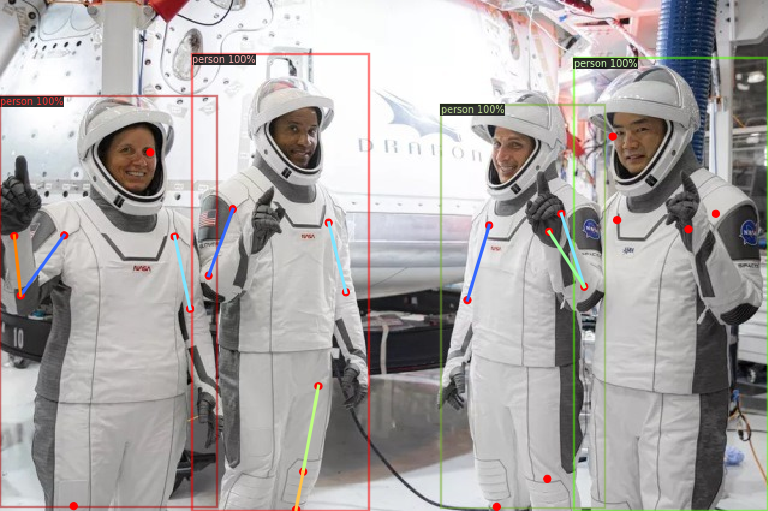

In [11]:
im = cv2.imread("data/raw/others/6-bulan-di-iss-astronaut-crew-1-lakukan-berbagai-penelitian-ilmiah-HscRrAoVep.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
display(Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))

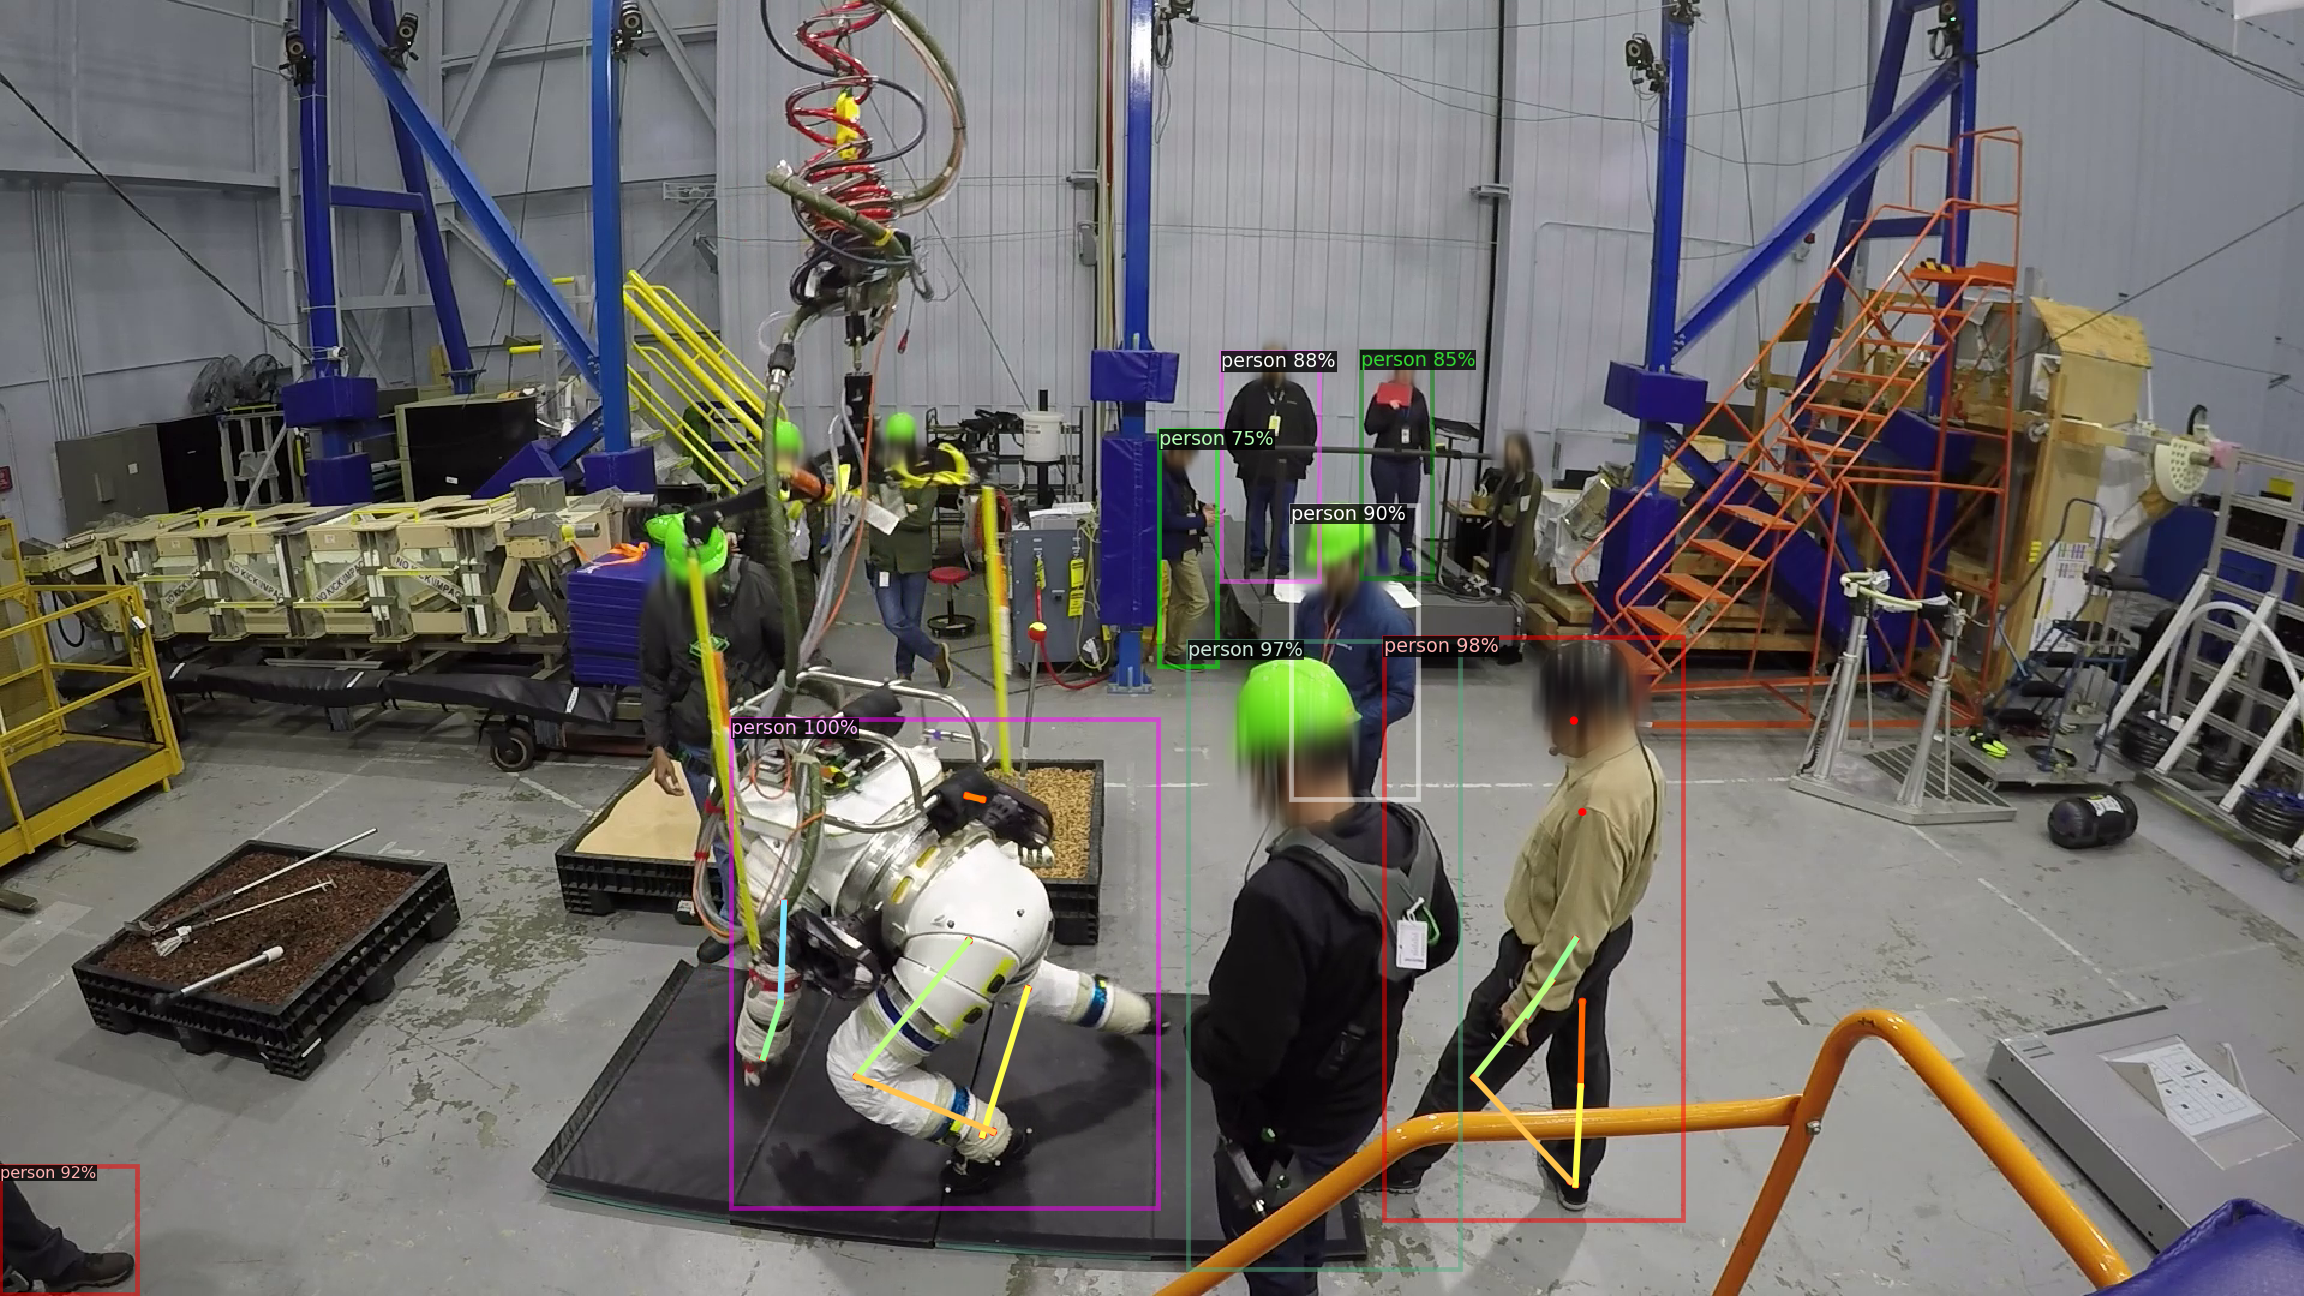

In [12]:
im = cv2.imread("data/raw/test/images/080202.png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
display(Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))

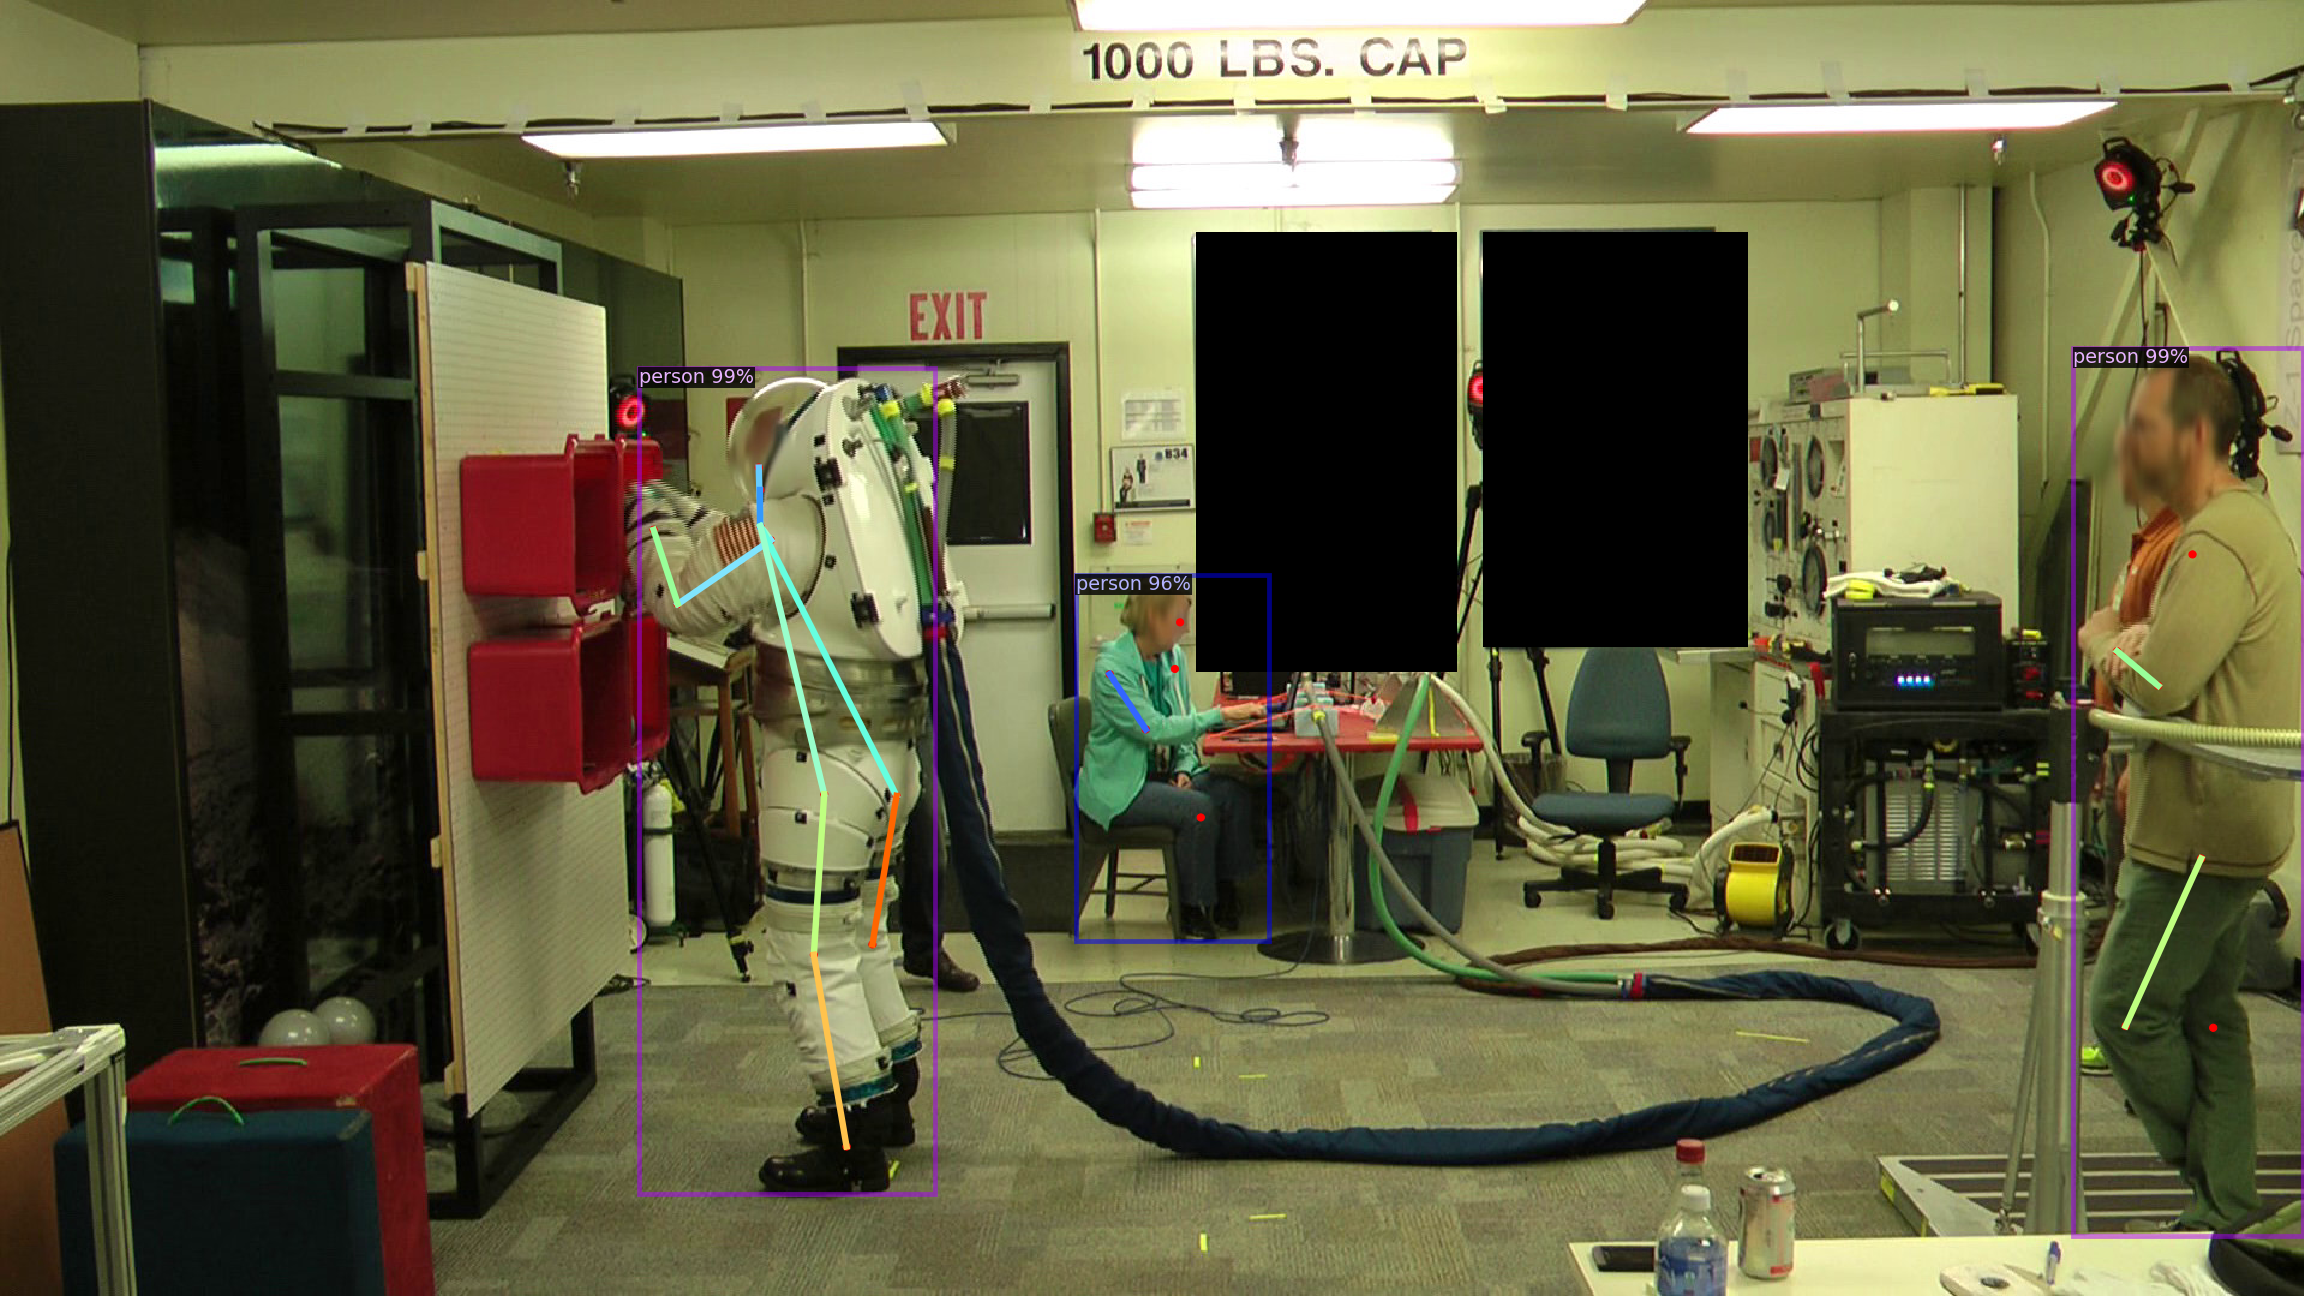

In [13]:
im = cv2.imread("data/raw/test/images/404058.png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

display(Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))

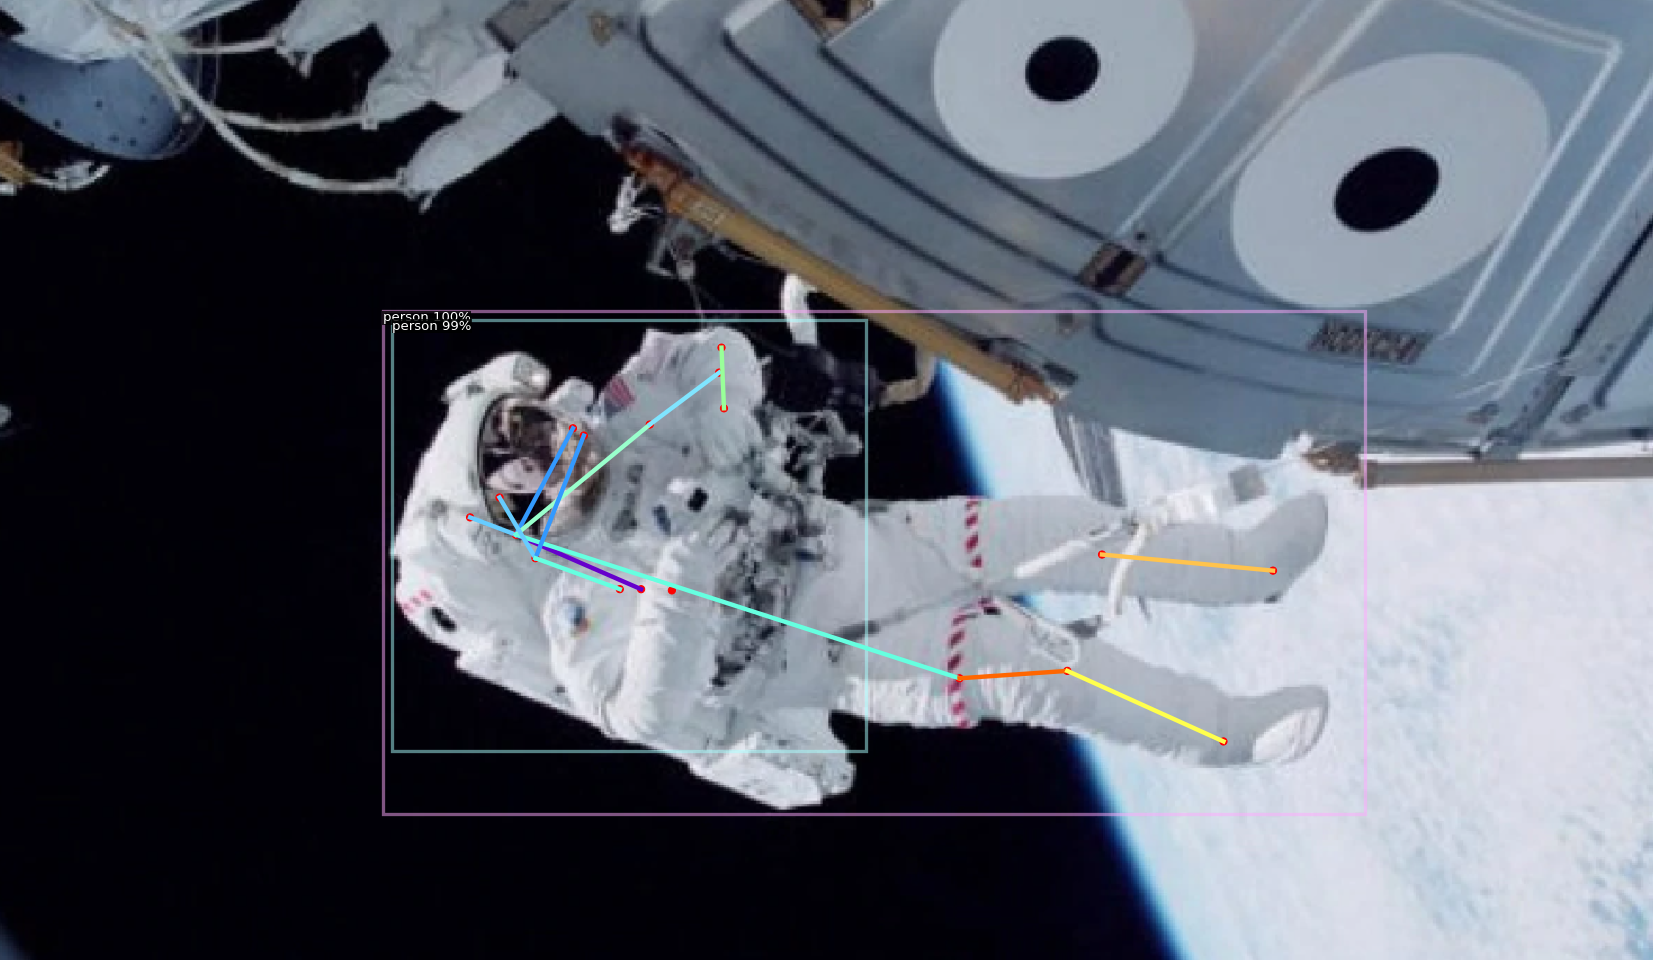

In [14]:
im = cv2.imread("data/raw/train/images/084510.png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

display(Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))

In [ ]:
im = cv2.imread("data/raw/train/images/621875.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

display(Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))

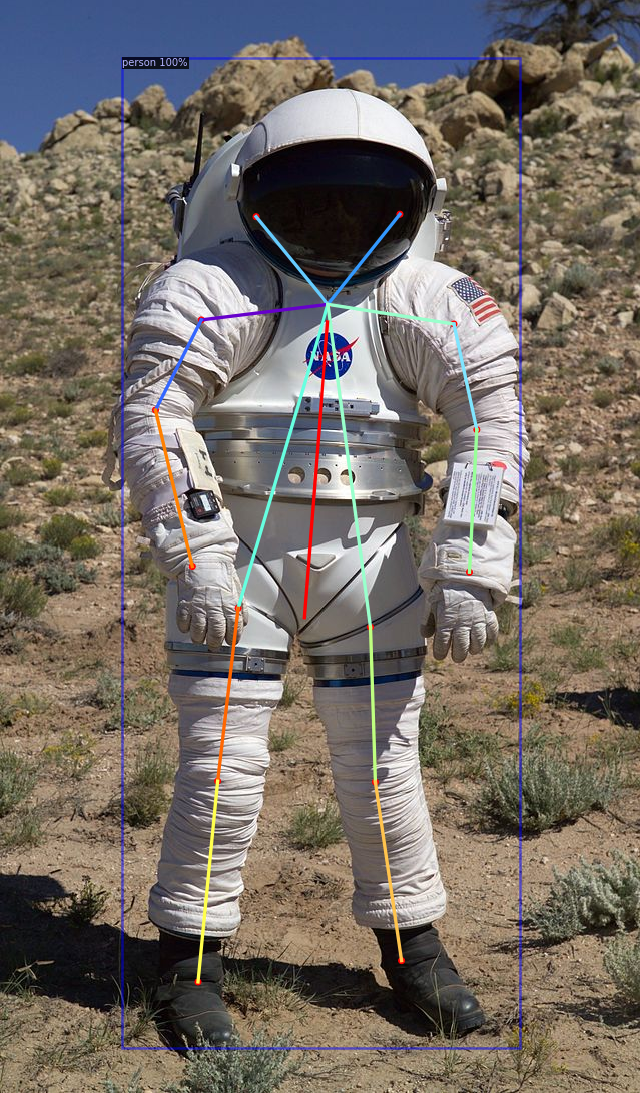

In [53]:
im = cv2.imread("data/raw/train/images/771734.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

display(Image.fromarray(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))

In [35]:
np.round(np.array(outputs["instances"].pred_keypoints[0]), 0)

array([[ 392.,  431.,    0.],
       [ 477.,  357.,    0.],
       [ 430.,  446.,    0.],
       [ 534.,  491.,    0.],
       [ 558.,  582.,    0.],
       [ 623.,  615.,    0.],
       [ 541.,  354.,    0.],
       [ 599.,  310.,    0.],
       [ 609.,  341.,    0.],
       [ 800.,  565.,    0.],
       [ 889.,  559.,    0.],
       [1020.,  618.,    0.],
       [ 802.,  464.,    0.],
       [ 918.,  462.,    0.],
       [1061.,  476.,    0.]], dtype=float32)

In [36]:
np.round(np.array(outputs["instances"].pred_keypoints[1]), 0)

array([[416., 415.,   0.],
       [487., 363.,   0.],
       [446., 465.,   0.],
       [377., 464.,   0.],
       [348., 465.,   0.],
       [560., 492.,   0.],
       [573., 291.,   0.],
       [601., 290.,   0.],
       [603., 340.,   0.],
       [516., 491.,   0.],
       [503., 529.,   0.],
       [658., 624.,   0.],
       [701., 503.,   0.],
       [601., 309.,   0.],
       [589., 337.,   0.]], dtype=float32)

In [38]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("spacesuit_dataset", ("bbox", "keypoints"), False, output_dir=cfg.OUTPUT_DIR)

In [47]:
from detectron2 import structures

structures.pairwise_iou(outputs['instances'].pred_boxes[0], outputs['instances'].pred_boxes[0])

tensor([[1.]])

In [48]:
structures.pairwise_iou(outputs['instances'].pred_boxes[1], outputs['instances'].pred_boxes[0])

tensor([[0.4136]])

In [49]:
structures.pairwise_iou(outputs['instances'].pred_boxes[0], outputs['instances'].pred_boxes[1])

tensor([[0.4136]])

In [ ]:
structures.pairwise_iou(outputs['instances'].pred_boxes[0], outputs['instances'].pred_boxes[1])